In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import os
import keras
import keras_nlp
import numpy as np
import PIL
import requests
import io
import matplotlib
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

os.environ["KERAS_BACKEND"] = "jax"
keras.config.set_floatx("bfloat16")

2024-08-01 10:20:44.773395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 10:20:44.773532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 10:20:44.919016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
paligemma = keras_nlp.models.PaliGemmaCausalLM.from_preset("pali_gemma_3b_mix_224")
paligemma.summary()

Attaching 'model.safetensors' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3

Preprocessor: "pali_gemma_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)          │                                             257,152 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "pali_gemma_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,923,335,408 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,923,335,408 (5.45 GB)

 Trainable params: 2,923,335,408 (5.45 GB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import requests
import io
import numpy as np
import PIL.Image
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def crop_and_resize(image, target_size):
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.crop((left, top, right, bottom)).resize(target_size)

def read_image(source, target_size):
    if source.startswith(('http://', 'https://')):
        contents = io.BytesIO(requests.get(source).content)
        image = PIL.Image.open(contents)
    else:
        image = PIL.Image.open(source)
    
    image = crop_and_resize(image, target_size)
    image = np.array(image)
    
    # Remove alpha channel if necessary
    if image.shape[2] == 4:
        image = image[:, :, :3]
    
    return image

def parse_bbox_and_labels(detokenized_output: str):
    matches = re.finditer(
        r'<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
        r' (?P<label>.+?)( ;|$)',
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
        labels.append(d['label'])
    return np.array(boxes), np.array(labels)

def display_boxes(image, boxes, labels, target_size):
    h, w = target_size
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * [h, w, h, w]
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        # Add label
        plt.text(x, y, labels[i], color='red', fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    plt.show()

def display_segment_output(image, segment_mask, target_size):
    # Calculate scaling factors
    h, w = target_size
    x_scale = w / 64
    y_scale = h / 64

    # Create coordinate grids for the new image
    x_coords = np.arange(w)
    y_coords = np.arange(h)
    x_coords = (x_coords / x_scale).astype(int)
    y_coords = (y_coords / y_scale).astype(int)
    resized_array = segment_mask[y_coords[:, np.newaxis], x_coords]
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Overlay the mask with transparency
    ax.imshow(resized_array, cmap='jet', alpha=0.5)

    plt.show()


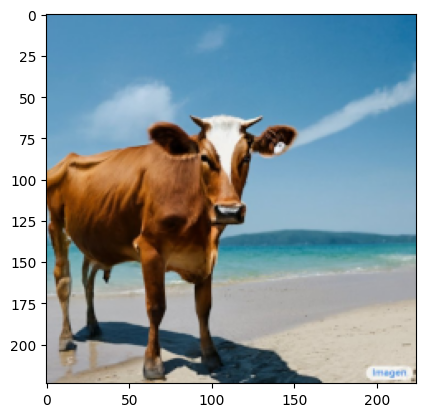

In [8]:
target_size = (224, 224)
image_url = 'https://storage.googleapis.com/keras-cv/models/paligemma/cow_beach_1.png'
cow_image = read_image(image_url, target_size)
matplotlib.pyplot.imshow(cow_image)

In [9]:
prompt = 'answer en where is the cow standing?\n'
# prompt = 'svar no hvor står kuen?'
# prompt = 'answer fr quelle couleur est le ciel?'
# prompt = 'responda pt qual a cor do animal?'
output = paligemma.generate(
    inputs={
        "images": cow_image,
        "prompts": prompt,
    }
)
print(output)

answer en where is the cow standing?
beach


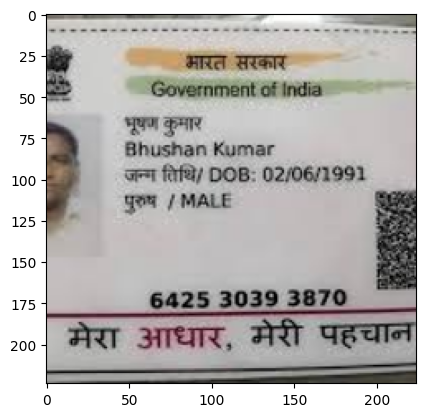

In [10]:
target_size = (224, 224)
image_url = '/kaggle/input/aadhar-and-number-plate-sample-images/aadhar1.jpg'
aadhar1 = read_image(image_url, target_size)
matplotlib.pyplot.imshow(aadhar1)

In [11]:
prompt = 'answer en describe the image?\n'
# prompt = 'svar no hvor står kuen?'
# prompt = 'answer fr quelle couleur est le ciel?'
# prompt = 'responda pt qual a cor do animal?'
output = paligemma.generate(
    inputs={
        "images": aadhar1,
        "prompts": prompt,
    }
)
print(output)

answer en describe the image?
id card


In [12]:
prompt = 'ocr\n'
# prompt = 'svar no hvor står kuen?'
# prompt = 'answer fr quelle couleur est le ciel?'
# prompt = 'responda pt qual a cor do animal?'
output = paligemma.generate(
    inputs={
        "images": aadhar1,
        "prompts": prompt,
    }
)
print(output)

ocr
भारत सरकार
Government of India
भूषण कुमार
Bhushan Kumar
जन्म तिथि: DOB: 02/06/1991 पुरुष / MALE
6425 3039 3870
मेरा आधार, मेरी पहचान


In [18]:
prompt = ''
# prompt = 'svar no hvor står kuen?'
# prompt = 'answer fr quelle couleur est le ciel?'
# prompt = 'responda pt qual a cor do animal?'
output = paligemma.generate(
    inputs={
        "images": aadhar1,
        "prompts": prompt,
    }
)
print(output)

ocr in json
भारत सरकार
Government of India
भूषण कुमार
Bhushan Kumar
जन्म तिथि: DOB: 02/06/1991 पुरुष / MALE
6425 3039 3870
मेरा आधार, मेरी पहचान


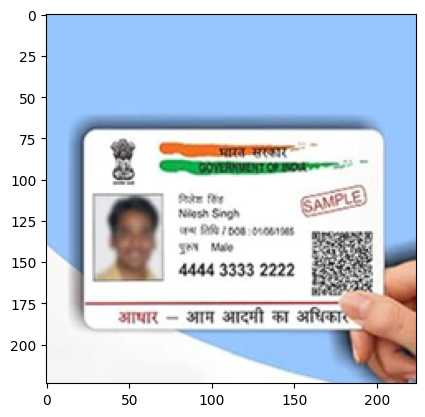

In [19]:
target_size = (224, 224)
image_url = '/kaggle/input/aadhar-and-number-plate-sample-images/aadhar2.jpg'
aadhar2 = read_image(image_url, target_size)
matplotlib.pyplot.imshow(aadhar2)

In [20]:
prompt = 'ocr\n'
# prompt = 'svar no hvor står kuen?'
# prompt = 'answer fr quelle couleur est le ciel?'
# prompt = 'responda pt qual a cor do animal?'
output = paligemma.generate(
    inputs={
        "images": aadhar2,
        "prompts": prompt,
    }
)
print(output)

ocr
SAMPLE
निशांत सिंह
Nikesh Singh
पता-पति / DOB: 01/08/1985
जन्म: Male
4444 3333 2222
आपार - आप आदमी का अधिकार


In [34]:
def f(image, prompt='ocr\n'):
    target_size = (224, 224)
    image_url = image
    image = read_image(image_url, target_size)
    matplotlib.pyplot.imshow(image)
    prompt = prompt
    # prompt = 'svar no hvor står kuen?'
    # prompt = 'answer fr quelle couleur est le ciel?'
    # prompt = 'responda pt qual a cor do animal?'
    output = paligemma.generate(
        inputs={
            "images": image,
            "prompts": prompt,
        }
    )
    print(output)

ocr
भारत सरकार
Government of India
निरजान कुमार
Niranjan Kumar
जन्म तिथि / DOB: 12/04/2000 पुरुष / Male
4835 8622 6030
आधार - आम आदमी का अधिकार


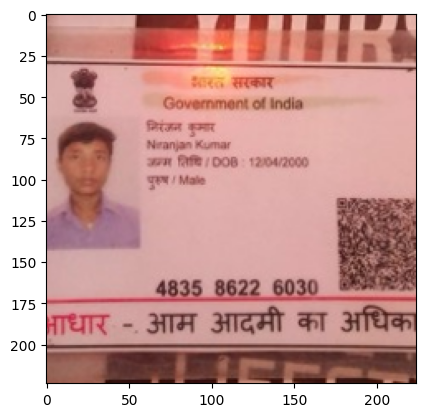

In [35]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/aadhar4.jpeg')

ocr
भारत सरकार
Government of India
Subhash Singh
DOB: 05/04/2005
Male
4422 0594 6619
चार - आम आदमी का अधिक


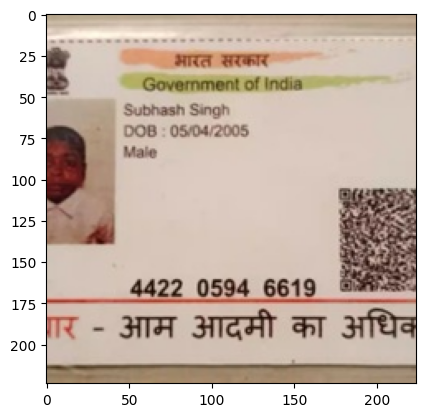

In [36]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/aadhar3.jpeg')

ocr
भारत सरकार
ग
NAME OF INDIA
नाम / Name:
Adarsh kumar
जन्म तिथि / DOB: 17/06/1995 पुरुष / Male
095237614258
आधार - आदमी का अधिकार


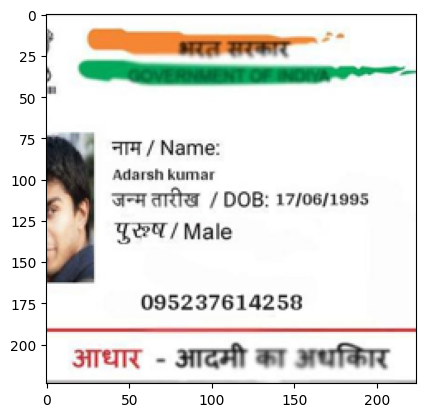

In [38]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/aadhar5.jpeg')

ocr
MH 20 EE 7602


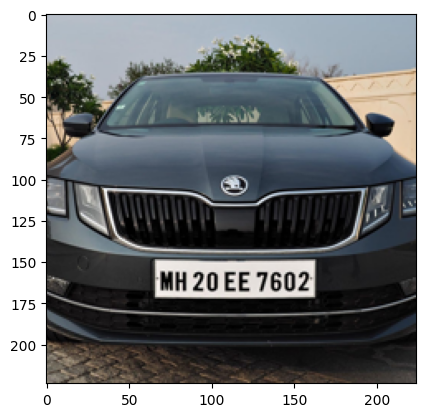

In [39]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/car1.jpg')

ocr
30KM
SPEED
alamy
झारखंड
BP2-A4904
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


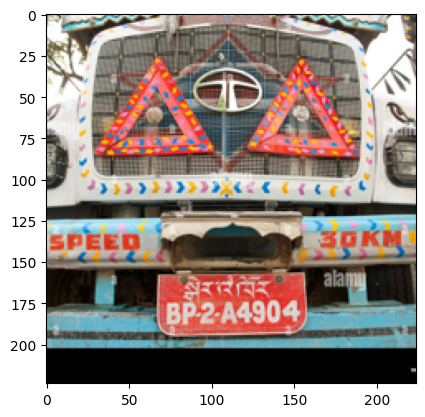

In [41]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/truck1.jpg')

ocr
TATA
TN 50 H3371
Picxy


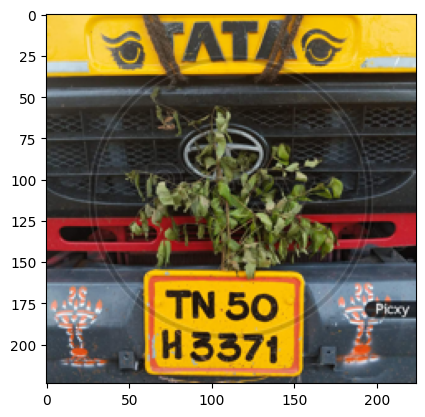

In [42]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/truck2.jpg')

ocr
ALLINDIA
PERMIT
GOODS
CARRIER
1000
1000
RJ15
D6787


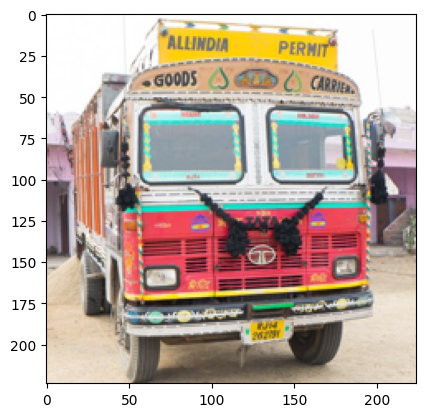

In [43]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/truck3.jpg')

ocr
TH 72 20


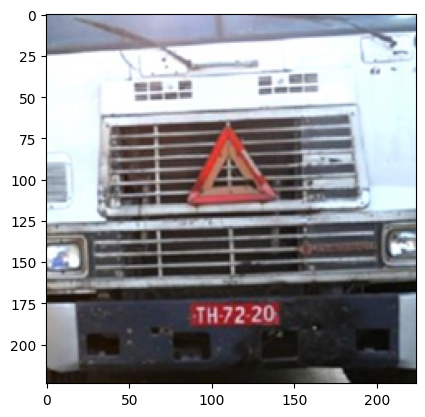

In [44]:
f('/kaggle/input/aadhar-and-number-plate-sample-images/truck4.jpg')

In [21]:
prompts = [
    'answer en where is the cow standing?\n',
    'answer en what color is the cow?\n',
    'describe en\n',
    'detect cow\n',
    'segment cow\n',
]
images = [cow_image, cow_image, cow_image, cow_image, cow_image]
outputs = paligemma.generate(
    inputs={
        "images": images,
        "prompts": prompts,
    }
)
for output in outputs:
    print(output)

answer en where is the cow standing?
beach
answer en what color is the cow?
brown
describe en
A brown cow stands on the wet sand at the beach, its head resting on its legs. The sky is clear and blue with a few white clouds. The water is calm and blue, reflecting the sky. The cow's horns are sharp and its eyes are bright. The sand is wet and the waves crash gently against the shore. The cow's shadow stretches long across the sand. The photographer's logo is visible in the bottom right corner of the image.
detect cow
<loc0274><loc0000><loc1022><loc0688> cow
segment cow
<loc0278><loc0000><loc1012><loc0686><seg028><seg051><seg116><seg113><seg007><seg065><seg057><seg023><seg081><seg126><seg019><seg118><seg016><seg102><seg003><seg068>


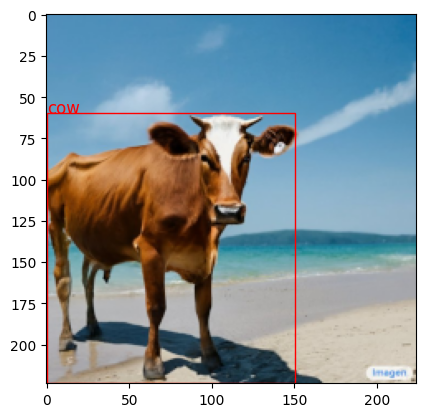

In [22]:
prompt = 'detect cow\n'
output = paligemma.generate(
    inputs={
        "images": cow_image,
        "prompts": prompt,
    }
)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(cow_image, boxes, labels, target_size)

In [23]:
# @title  Fetch big_vision code and install dependencies.
import os
import sys

!git clone --quiet --branch=main --depth=1 \
    https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


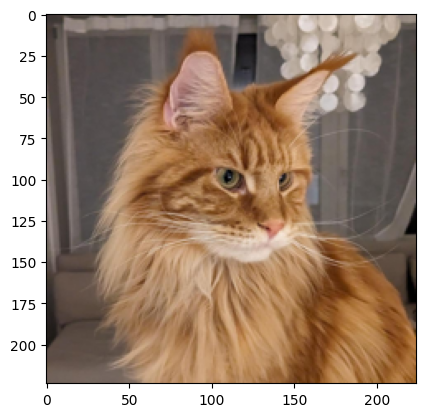

In [24]:
cat = read_image('https://big-vision-paligemma.hf.space/file=examples/barsik.jpg', target_size)
matplotlib.pyplot.imshow(cat)

In [25]:
import  big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval
reconstruct_masks = segeval.get_reconstruct_masks('oi')
def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      + ''.join(f'<seg(?P<s{i}>\d\d\d)>' for i in range(16)),
      detokenized_output,
  )
  boxes, segs = [], []
  fmt_box = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt_box(d['y0']), fmt_box(d['x0']), fmt_box(d['y1']), fmt_box(d['x1'])])
    segs.append([int(d[f's{i}']) for i in range(16)])
  return np.array(boxes), np.array(reconstruct_masks(np.array(segs)))

In [26]:
prompt = 'segment cat\n'
output = paligemma.generate(
    inputs={
        "images": cat,
        "prompts": prompt,
    }
)

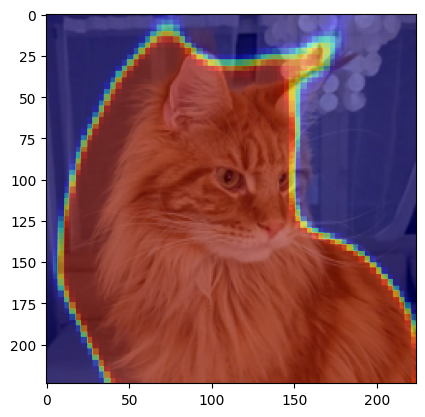

In [27]:
_, seg_output = parse_segments(output)
display_segment_output(cat, seg_output[0], target_size)

# Try other models

In [28]:
# Preset name	Parameters	Description
# pali_gemma_3b_mix_224	2.92B	image size 224, mix fine tuned, text sequence length is 256
# pali_gemma_3b_mix_448	2.92B	image size 448, mix fine tuned, text sequence length is 512
# pali_gemma_3b_224	2.92B	image size 224, pre trained, text sequence length is 128
# pali_gemma_3b_448	2.92B	image size 448, pre trained, text sequence length is 512
# pali_gemma_3b_896	2.93B	image size 896, pre trained, text sequence length is 512 